In [10]:
import csv,sys, math, random, collections, pprint, json, os, gzip, pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Any
from itertools import groupby
from collections import defaultdict, Counter
from IPython.display import JSON, display_javascript, display_html, display
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
from patsy import dmatrices

print(sys.version)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

stoplist = {'eventUniqueId', 'timeEpoch', 'timeUTC', 'eventType'}

choice_event_keys = sorted(['CardPlacedInMachine', 'FlagPlaced', 'FlagMoved',
                     'CardPlacedInTray', 'CardSwapped', 
                     'RainbowPlantPlanted', 'PlantPlanted', 'CreatureSpawned'])
choice_nonevent_keys = sorted(['GameStart', 'CreatureStateChanged', 'PlantStateChanged', 'TreasureDespawned',
                        'CurrentScreenChanged', 'CreatureSelected', 'CreatureDeselected',
                        'TreasureSpawned', 'PlantWatered', 'TreasureOpened', 'CreatureDespawned',
                        'AllOrbsFilled', 'MushroomOrbFilled', 'WoodyOrbFilled', 'SeedPacketCountChanged',
                        'LeafyOrbFilled', 'FlagCancelled', 'CreatureLocked', 'CreatureUnlocked'])
progress_keys = sorted(['TreasureOpened', 'PlantWatered', 'RainbowPlantPlanted', 'AllOrbsFilled', 'MushroomOrbFilled',
                 'WoodyOrbFilled', 'LeafyOrbFilled'])
relevant_keys = sorted(choice_event_keys + progress_keys)
creature_keys_p1 = [f"player1Creature{j}" for j in range(1,4)]
creature_keys_p2 = [f"player2Creature{j}" for j in range(1,4)]
creatures = [creature_keys_p1,creature_keys_p2]
creature_stats = ['cardsExecuted','machineType','plantsPlanted','plantsWatered','starsEarned']

event_change_threshold = 30

3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0]


In [2]:
DEBUG = False

if DEBUG:
    num_datasets = 1
else:
    num_datasets = 5

In [3]:
def diff_elts(a: dict, b: dict) -> dict:
    output = {}
    if 'eventKey' in a:
        output['eventKey'] = a['eventKey']
    for ka in a.keys():
        if ka in b and ka not in stoplist:
            if isinstance(a[ka], dict):
                diff = diff_elts(a[ka], b[ka])
                if diff:
                    output[ka] = diff
            elif a[ka] != b[ka]:
                output[ka] = a[ka]
    if len(output.keys()) > 1:
        return output
    return False


def find_likely_player(datum: dict) -> tuple:
    if datum:
        player1 = any(e for e in datum.keys() if "layer1" in e)
        player2 = any(e for e in datum.keys() if "layer2" in e)
        if player1 or player2:
            return player1, player2
    return False, False


def apply_diff(player, elt):
    current_time = elt['timeEpoch']

    current_event = elt['eventKey']
    if current_event == player[2] or current_event in choice_nonevent_keys:
        return (player[0], current_time, player[2]), ""
    return (current_time, current_time, current_event), f"{player[2]} {player[0]} => {player[1]}"

In [4]:
pklfilename = "../lawrence.pkl"
lawrence_data = []
nysci_data = []

if not os.path.exists(pklfilename):
    filenames = random.sample([file.path for file in os.scandir("../data")], num_datasets)
    print(filenames)

    for filename in filenames:
        with gzip.open(filename, "rb") as f:
            print(f"\nJSON loading {filename}...", end="")
            t_data_list = list(json.load(f).values())
            print("DONE.")
            print(f"Data filtering {filename}...", end="")
            lawrence_data.extend(list(filter(lambda x: "Lawrence" == x["siteName"], t_data_list)))
            nysci_data.extend(list(filter(lambda x: "Lawrence" != x["siteName"], t_data_list)))
            print("DONE.")
        
    print("Sorting...", end="")
    lawrence_data = list(sorted(lawrence_data, key=lambda e: e["timeEpoch"]))
    nysci_data = list(sorted(nysci_data, key=lambda e: e["timeEpoch"]))
    print("DONE.")
    with open(pklfilename,"wb") as f:
        pickle.dump(lawrence_data, f, pickle.HIGHEST_PROTOCOL)
else:
    print("LOADING PKL...",end="")
    with open(pklfilename,"rb") as f:
        lawrence_data = pickle.load(f)
    print("DONE!")

if len(nysci_data) > 0:
    print(f"   NYSCI: {len(nysci_data)}: {nysci_data[0]['timeEpoch']} => {nysci_data[-1]['timeEpoch']}")
else:
    print(f"   NYSCI: NONE")
if len(lawrence_data) > 0:
    print(f"LAWRENCE: {len(lawrence_data)}: {lawrence_data[0]['timeEpoch']} => {lawrence_data[-1]['timeEpoch']}")
else:
    print(f"LAWRENCE: NONE")

LOADING PKL...DONE!
   NYSCI: NONE
LAWRENCE: 957778: 1560964321 => 1576476755


In [5]:
# set(map(lambda elt: elt['eventKey'], lawrence_data))
event_keys_list = ['AllOrbsFilled', 'CardPlacedInMachine', 'CardPlacedInTray', 'CardSwapped', 'CreatureDeselected', 'CreatureDespawned', 'CreatureLocked', 'CreatureSelected', 'CreatureSpawned', 'CreatureStateChanged', 'CreatureUnlocked', 'CurrentScreenChanged', 'FlagCancelled', 'FlagMoved', 'FlagPlaced', 'GameStart', 'LeafyOrbFilled', 'MushroomOrbFilled', 'PlantPlanted', 'PlantStateChanged', 'PlantWatered', 'RainbowPlantPlanted', 'SeedPacketCountChanged', 'TreasureDespawned', 'TreasureOpened', 'TreasureSpawned', 'WoodyOrbFilled']

In [6]:


plant_types = ['Woody','Mushroom','Leafy','Rainbow']
players = ['Player1', 'Player2']

def board_plant_diversity_metric(elt):
    if 'plants' not in elt or '0' not in elt['plants']:
        return 0
    total_plants = 0
    plants = [elt['plants'][k] for k in elt['plants']]
    plant_counter = Counter(plant_types)
    for plant in plants:
        plant_type = plant['plantType']
        player = str(plant['playerWhoPlanted'])
        if player in players:
            plant_counter[plant_type] += 1
    for plant_type in plant_types:
        total_plants += plant_counter[plant_type]
    if total_plants > 1:
        score = 1 - np.sum([(plant_counter[plant_type] * (plant_counter[plant_type] - 1.0)) for plant_type in plant_types]) / (total_plants * (total_plants - 1.0))
    else:
        score = 0
    return score

machine_types = ['Conditional','Sequential','Probability']
creatures = [f"player{i}Creature{j}" for i in range(1,3) for j in range(1,4)]

def find_creature_machines_in_elt(elt):
    output = []
    for creature in creatures:
        if creature in elt:
            if 'cardsExecuted' in elt[creature]:
                if int(elt[creature]['cardsExecuted']) > 0:
                    output.append(elt[creature]['machineType'])
    return output




def board_machine_diversity_metric(elt):
    machines = find_creature_machines_in_elt(elt)
    score = 1.0 * sum([1 for machine_type in machine_types if machine_type in machines]) / len(machine_types)
    return score



def live_players(grouped_elts):
    op1 = op2 = 0
    elt_prior = False
    for elt in grouped_elts:
        if elt_prior:
            elt_diff = diff_elts(elt, elt_prior)
            p1, p2 = find_likely_player(elt_diff)
            if p1: op1 = 1
            if p2: op2 = 1
            if 2 == p1 + p2: return 2
        elt_prior = elt
    return (op1 + op2)


# # board score vs. solo score? account for diversity of machine as well
# # bucket by player change?
# # <time, p1id, p2id, solo?,
# # p1_plant_diversity_score, p2_plant_diversity_score, board_plant_diversity_score, 
# # p1_machine_diversity_score, p2_machine_diversity_score, board_machine_diversity_score>

def progress_types(grouped_elts):
    return set([elt['eventKey'] for elt in grouped_elts if elt['eventKey'] in progress_keys])

def action_types(grouped_elts):
    return set([elt['eventKey'] for elt in grouped_elts if elt['eventKey'] in choice_event_keys])

def count_elts(grouped_elts):
    return len([elt['eventKey'] for elt in grouped_elts if elt['eventKey'] in relevant_keys])

def bucket_plant_diversity(grouped_elts):
    scores = list(filter(lambda x : x != 0, [board_plant_diversity_metric(elt) for elt in grouped_elts]))
    if len(scores) != 0:
        return (max(scores) - scores[0]) # how much did you change the diversity
    return 0

def bucket_machine_diversity(grouped_elts):
    scores = list(filter(lambda x : x != 0, [board_machine_diversity_metric(elt) for elt in grouped_elts]))
    if len(scores) != 0:
        return max(scores)
    return 0

def profile_group(grouped_elts):
    output = {}
    output['start_time'] = min([int(elt['timeEpoch']) for elt in grouped_elts])
    output['end_time'] = max([int(elt['timeEpoch']) for elt in grouped_elts])
    output['live_players'] = live_players(grouped_elts)
    output['plant_diversity'] = bucket_plant_diversity(grouped_elts)
    output['machine_diversity'] = bucket_machine_diversity(grouped_elts)
    return output

random_elts = random.sample(lawrence_data, k=10)
print(profile_group(random_elts))

# by person-in-group


{'start_time': 1561053054, 'end_time': 1573082424, 'live_players': 2, 'plant_diversity': 0.044243779383098314, 'machine_diversity': 1.0}


In [7]:
bucket_idle_split = 30
flaw = filter(lambda elt: elt['eventKey'] in relevant_keys, lawrence_data)

# two way split!
def split_by_idle(evts):
    evt_time = 0
    output = []
    current_bucket = []
    for elt in evts:
        prev_evt_time = evt_time
        evt_time = elt['timeEpoch']
        if (evt_time - prev_evt_time) > bucket_idle_split:
            if len(current_bucket) > 0:
                output.append(tuple([evt_time,current_bucket]))
                current_bucket = []
        current_bucket.append(elt)
    output.append(tuple([evt_time,current_bucket]))
    return output

gflaw = split_by_idle(flaw)

In [8]:
mgflaw = map(lambda tgrp: profile_group(list(tgrp[1])), gflaw)
lmgflaw = list(mgflaw)
print(random.choice(lmgflaw))
print(len(lmgflaw))

{'start_time': 1562199761, 'end_time': 1562199761, 'live_players': 0, 'plant_diversity': 0.0, 'machine_diversity': 0.6666666666666666}
5786


In [31]:
df = pd.DataFrame(lmgflaw)
df['bucket_length'] = df.end_time - df.start_time
display(df.groupby("live_players").describe())
display(df.groupby("live_players").mean())

start_time                                            \
                  count          mean           std           min   
live_players                                                        
0                2714.0  1.569143e+09  5.901973e+06  1.560965e+09   
1                1497.0  1.570306e+09  5.790779e+06  1.560964e+09   
2                1575.0  1.570324e+09  5.363180e+06  1.560964e+09   

                                                                     end_time  \
                       25%           50%           75%           max    count   
live_players                                                                    
0             1.562647e+09  1.571775e+09  1.573457e+09  1.576461e+09   2714.0   
1             1.562976e+09  1.572479e+09  1.576038e+09  1.576460e+09   1497.0   
2             1.562881e+09  1.571947e+09  1.573435e+09  1.576461e+09   1575.0   

                            ... machine_diversity      bucket_length  \
                      mean  ...               75%  max         count   
live_players                ...                                        
0             1.569143e+09  ...          0.333333  1.0        2714.0   
1             1.570306e+09  ...          0.333333  1.0        1497.0   
2             1.570325e+09  ...          0.666667  1.0        1575.0   

                                                                        
                    mean         std  min   25%    50%    75%      max  
live_players                                                            
0               0.934046    5.545017  0.0   0.0    0.0    0.0    123.0  
1              56.291917   90.678774  0.0  19.0   33.0   66.0   2522.0  
2             368.205079  808.348187  4.0  57.0  151.0  407.0  24065.0  

[3 rows x 40 columns]

,start_time,end_time,plant_diversity,machine_diversity,bucket_length
live_players,,,,,
0,1.569143e+09,1.569143e+09,0.000215,0.348931,0.934046
1,1.570306e+09,1.570306e+09,0.004378,0.355377,56.291917
2,1.570324e+09,1.570325e+09,0.020456,0.519365,368.205079


In [32]:
# sns.lineplot(data=df, x=df.index, y='plant_diversity', hue='live_players')

# df['score'] = df.plant_diversity + df.machine_diversity
y, X = dmatrices('machine_diversity ~ bucket_length + live_players', data=df, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())
print(res.params)


                            OLS Regression Results                            
Dep. Variable:      machine_diversity   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     596.1
Date:                Fri, 21 May 2021   Prob (F-statistic):          4.27e-236
Time:                        16:00:38   Log-Likelihood:                 866.15
No. Observations:                5786   AIC:                            -1726.
Df Residuals:                    5783   BIC:                            -1706.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.3370      0.004     88.750

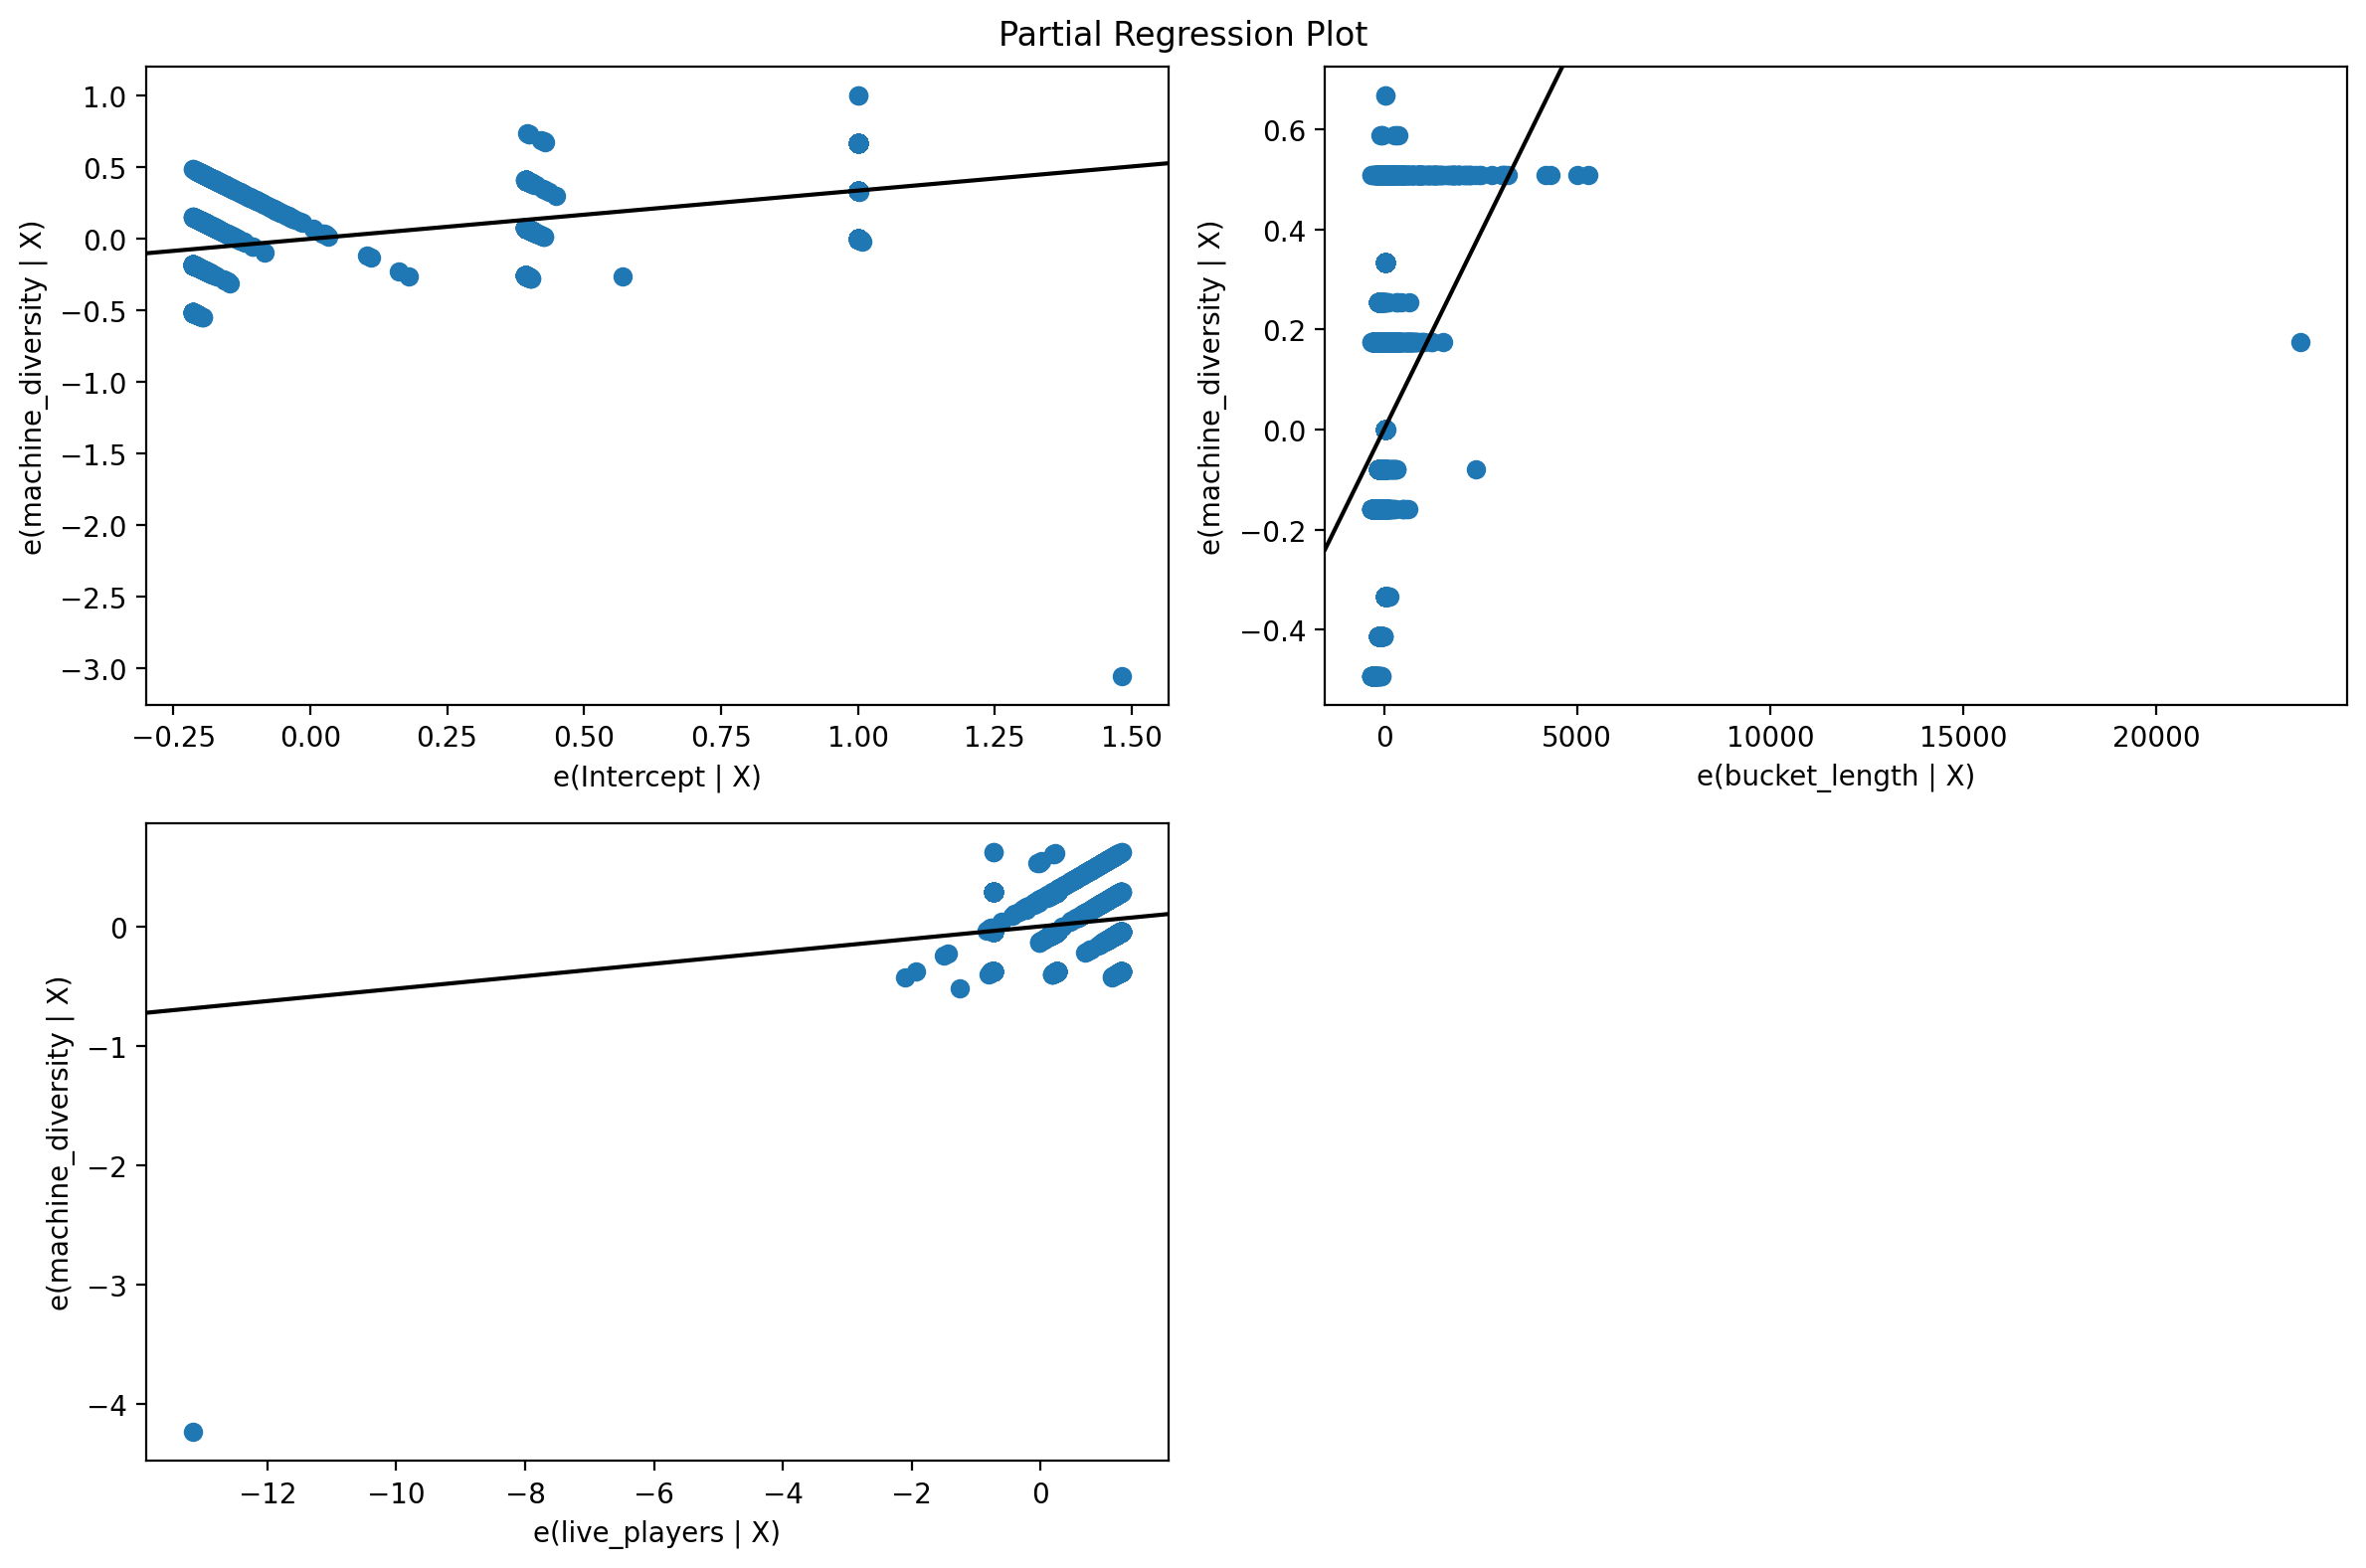

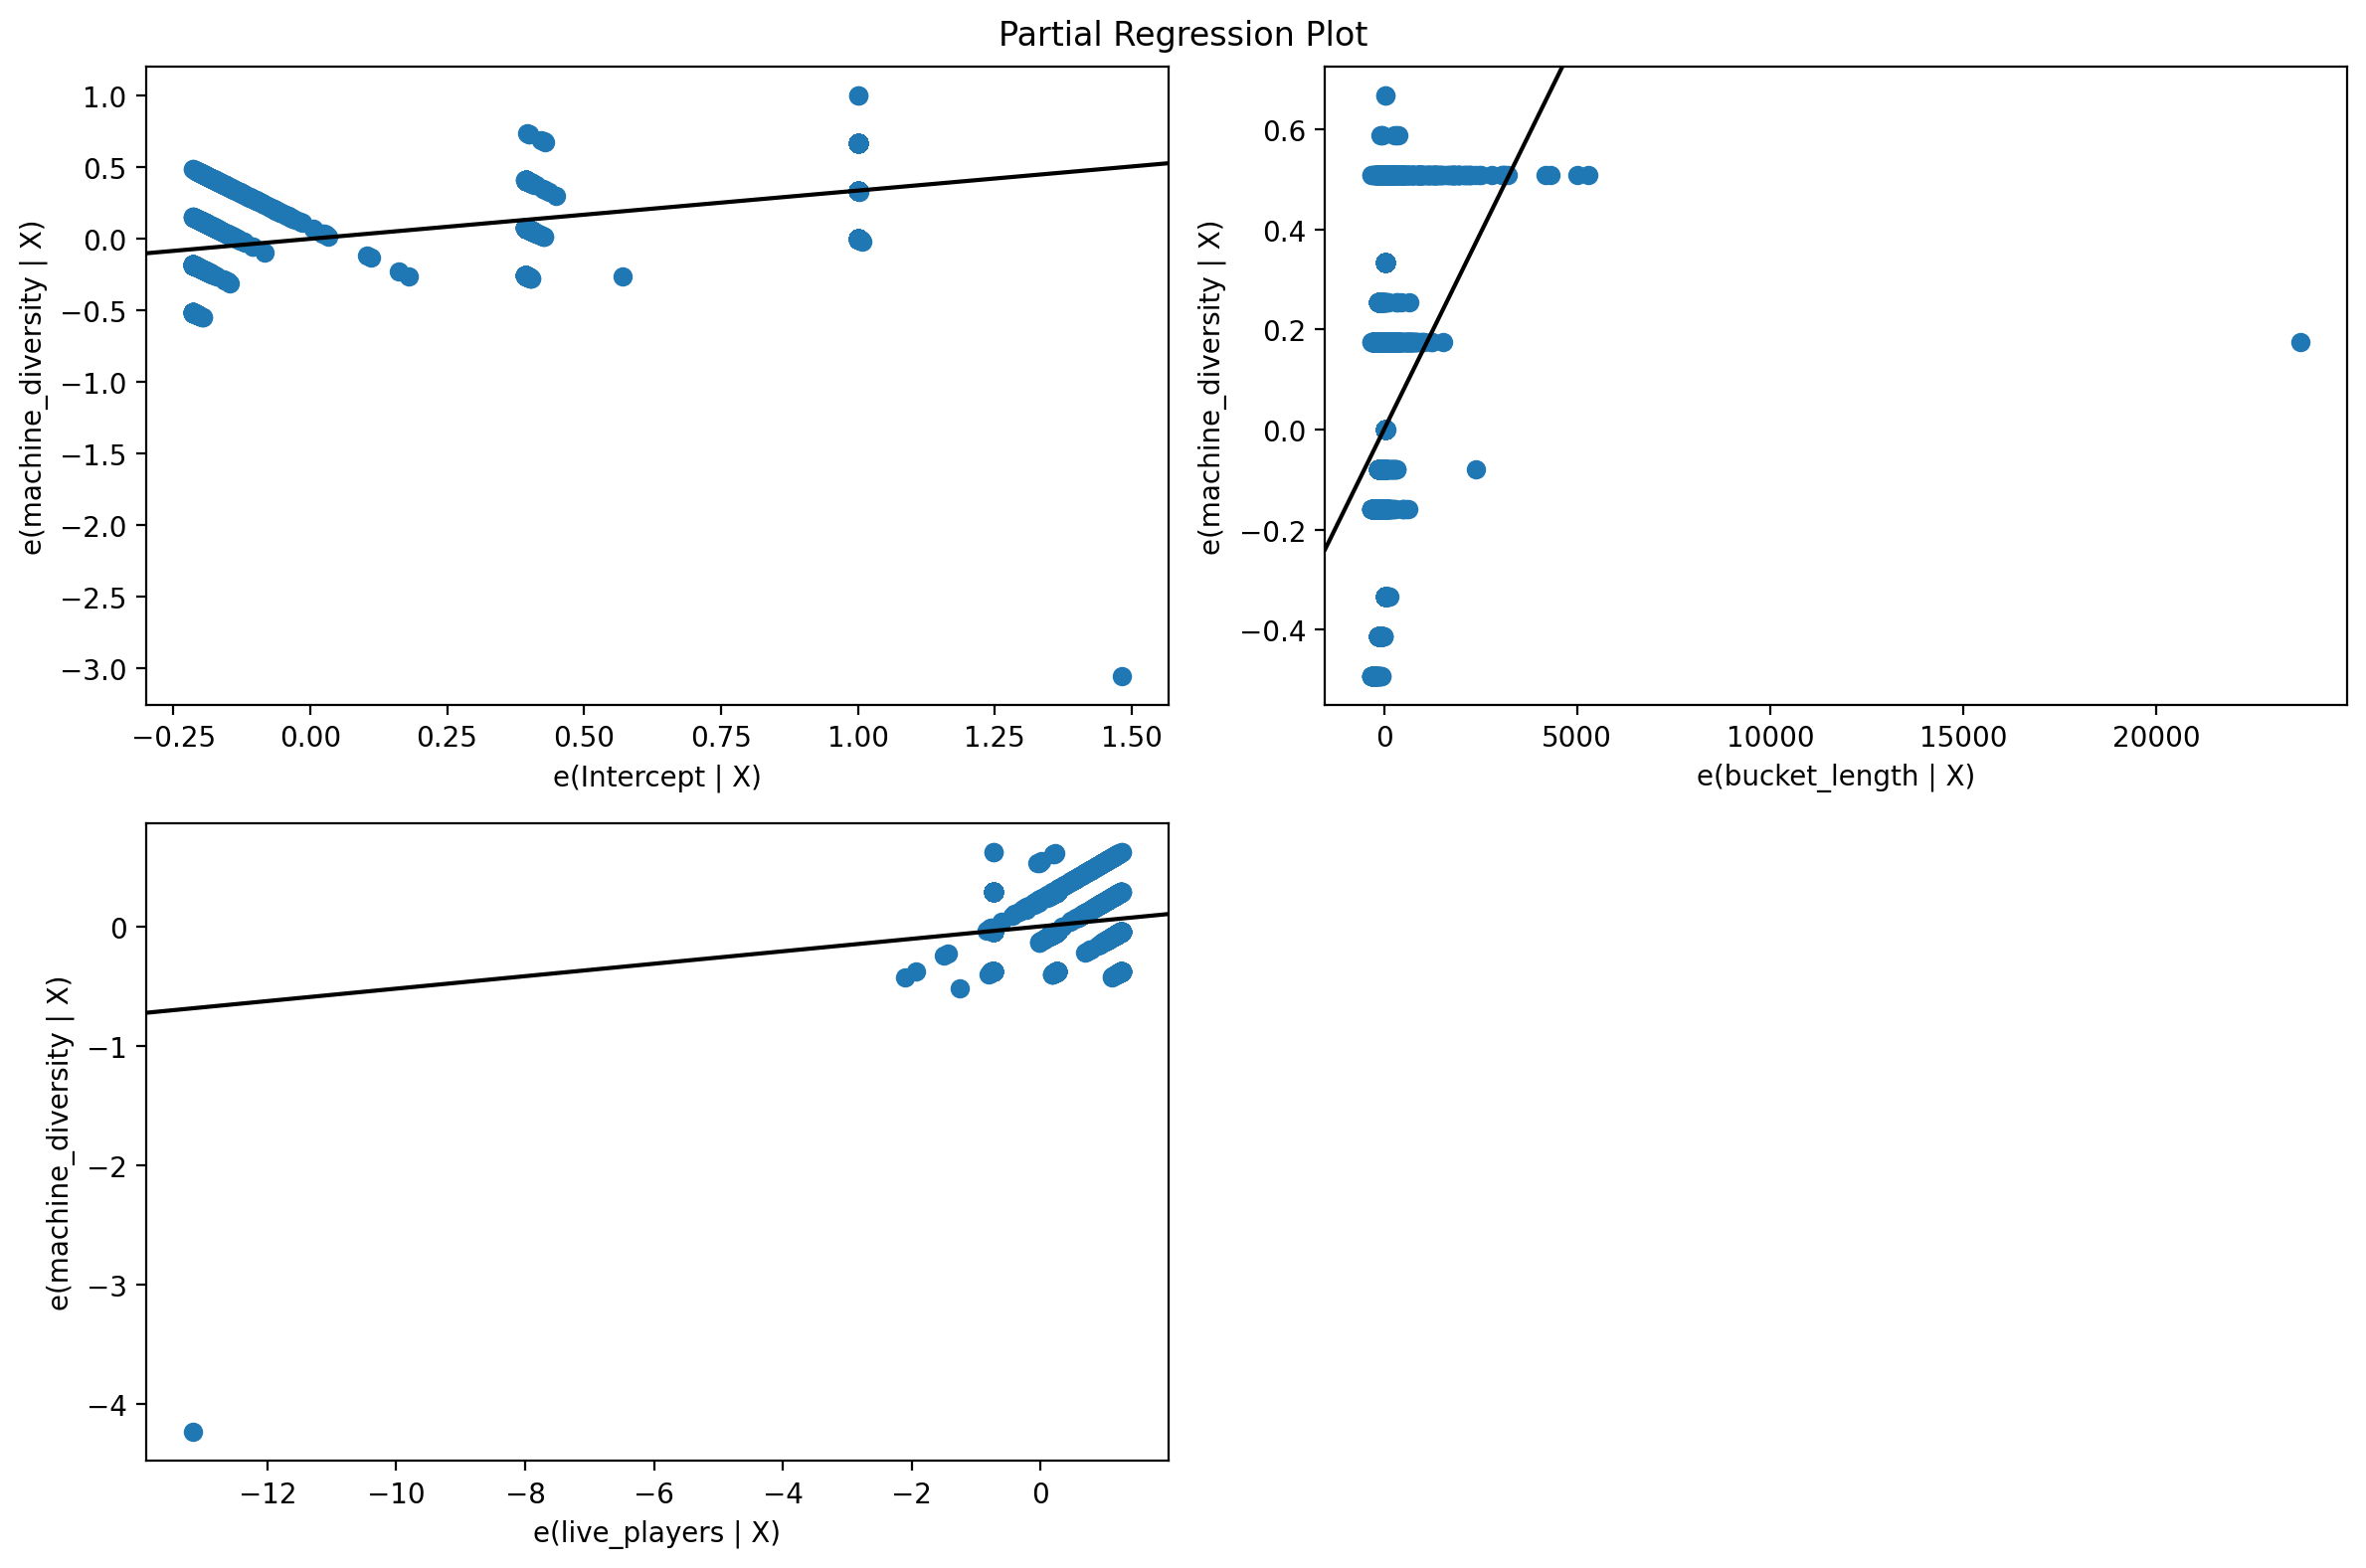

In [33]:
# sm.graphics.plot_partregress('machine_diversity', 'live_players', ['bucket_length'], data=df, obs_labels=False)
sm.graphics.plot_partregress_grid(res)


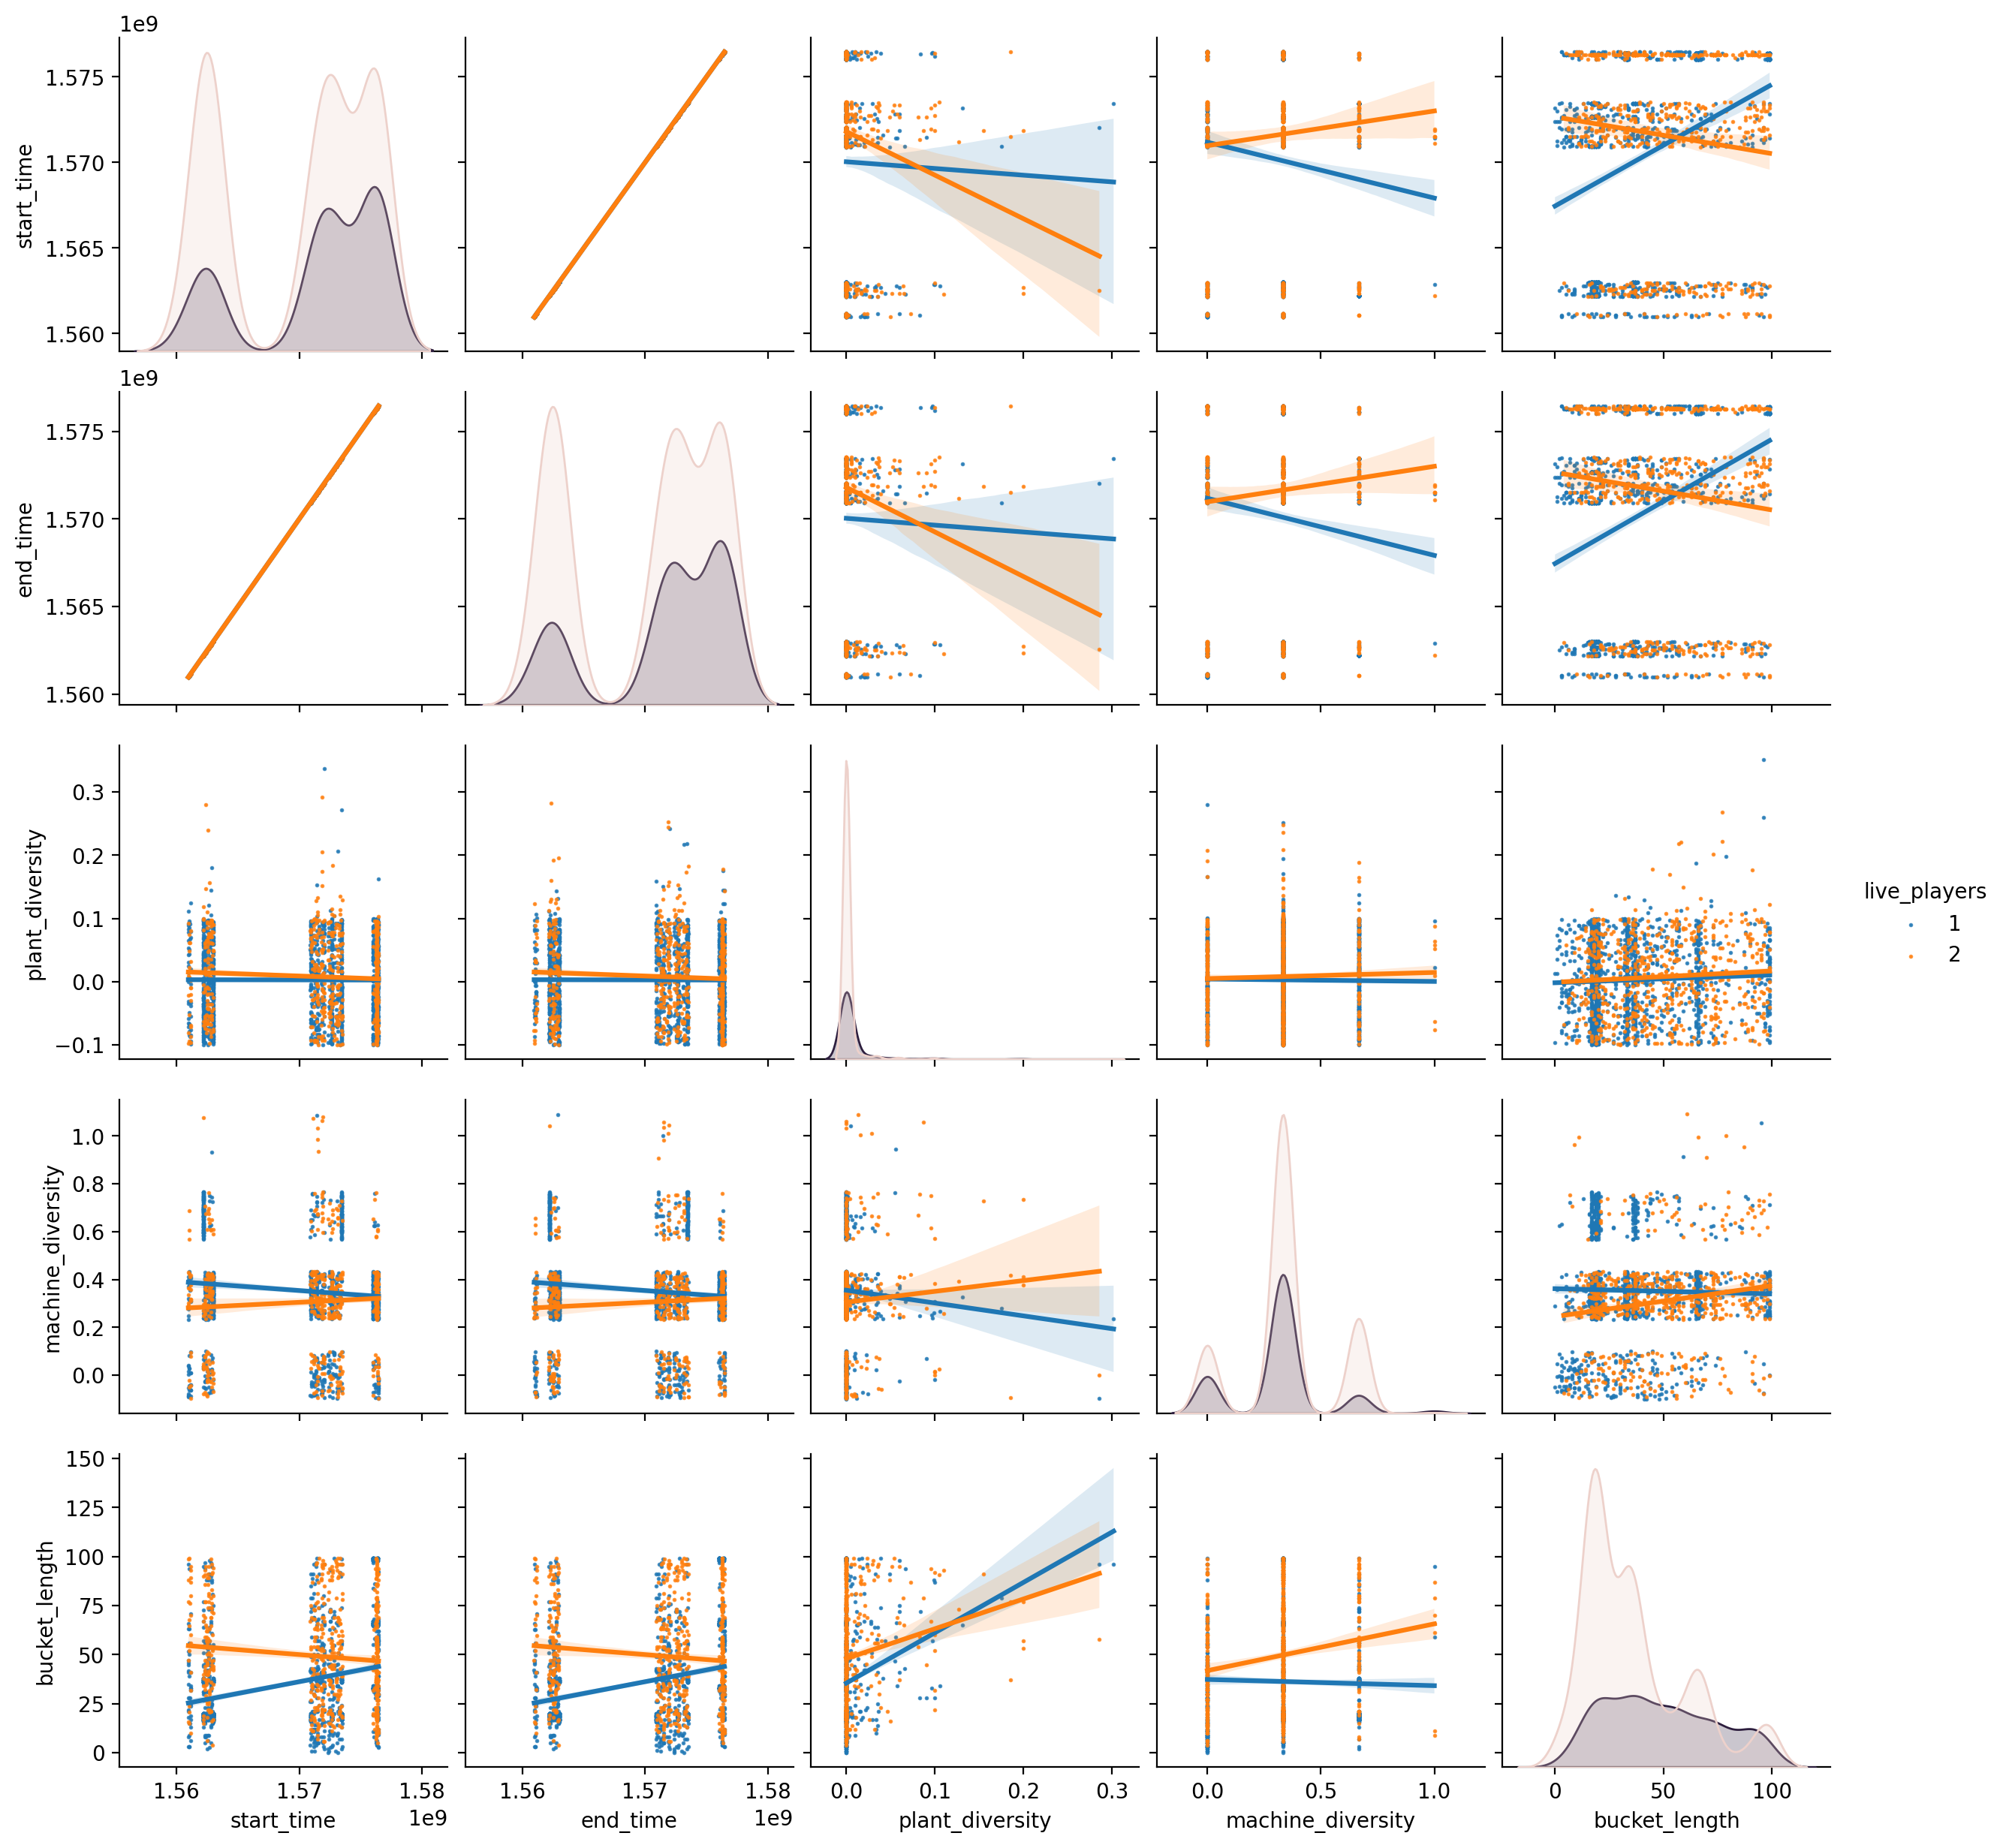

In [51]:
# x = bucket_length, y = score, color = live_player
sns.pairplot(data=df[(df.bucket_length<100) & (df.live_players>0)], 
             hue="live_players", kind="reg", plot_kws=dict(y_jitter=0.1,scatter_kws=dict(s=1)))

# sns.pairplot(data=df[(df.bucket_length<1000) & (df.live_players>0)], 
#              hue="live_players", kind="reg", plot_kws=dict(scatter_kws=dict(s=0)))

In [12]:
print(len(gflaw))
end = False
for buckets in gflaw:
    if not end:
        bucket = buckets[1]
        output = []
        for elt in bucket:
            output.append(elt['eventKey'])
        print(",".join(output))
        end = True

5786
FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagPlaced,FlagMoved,FlagMoved,FlagMoved,CardPlacedInMachine,FlagMoved,CardPlacedInMachine,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,CardPlacedInMachine,CardPlacedInTray,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,FlagMoved,CardPlacedInMachine,FlagMoved,FlagMoved,FlagMoved,FlagMoved,CreatureSpawned,FlagMoved,PlantPlanted


In [13]:
to_dummy = lambda header, data : [1 if h in data else 0 for h in header]
# print(to_dummy(choice_event_keys,{'CardPlacedInMachine', 'FlagPlaced'}))


header = ['epoch','live_players','num_elts'] + progress_keys + choice_event_keys 
csvoutfilename = "dummy_coded_lawrence_2021idc.csv"
csvout = open(csvoutfilename,"w")
csvout.write(",".join(header) + "\n")
for profile in lmgflaw:
    output_row = [  profile[0], profile[1]['live_players'],profile[1]['num_elts'] ] + to_dummy(progress_keys,profile[1]['progress_types']) + to_dummy(choice_event_keys,profile[1]['action_types'])
    csvout.write(",".join(map(str,output_row)) + "\n")
csvout.close()

In [14]:
df = pd.read_csv(csvoutfilename)

In [15]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols


df_lm=ols('TreasureOpened ~ live_players + FlagMoved + CreatureSpawned + PlantPlanted + CardPlacedInMachine', data=df[df.num_elts>200]).fit() #Specify C for Categorical
print(sm.stats.anova_lm(df_lm))

                        df      sum_sq   mean_sq         F    PR(>F)
live_players           1.0    2.226623  2.226623  9.224311  0.002491
FlagMoved              1.0    0.254517  0.254517  1.054397  0.304906
CreatureSpawned        1.0    2.250963  2.250963  9.325146  0.002359
PlantPlanted           1.0    1.961150  1.961150  8.124527  0.004516
CardPlacedInMachine    1.0    0.010064  0.010064  0.041691  0.838279
Residual             606.0  146.280138  0.241386       NaN       NaN


In [16]:
import math
df['orb'] = df.LeafyOrbFilled + df.MushroomOrbFilled + df.WoodyOrbFilled

df.orb = df.orb.apply(lambda x : x/3.0).apply(np.ceil).astype('int32')
dflive = df[df.num_elts>20]
dflive.head()

,epoch,live_players,num_elts,AllOrbsFilled,LeafyOrbFilled,MushroomOrbFilled,PlantWatered,RainbowPlantPlanted,TreasureOpened,WoodyOrbFilled,CardPlacedInMachine,CardPlacedInTray,CardSwapped,CreatureSpawned,FlagMoved,FlagPlaced,PlantPlanted,RainbowPlantPlanted.1,orb
0,1560964462,2,54,0,0,0,0,0,0,0,1,1,0,1,1,1,1,0,0
1,1560964680,1,93,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1560964910,2,175,1,0,1,1,0,0,0,1,0,0,1,1,1,1,0,1
4,1560966426,2,239,0,0,0,1,1,0,0,1,0,0,1,1,1,1,1,0
5,1560966879,2,971,1,1,1,1,0,0,1,1,0,1,1,1,1,1,0,1


In [17]:
dflive[dflive.columns[1:]].mean()

live_players               1.723338
num_elts                 330.117315
AllOrbsFilled              0.391468
LeafyOrbFilled             0.399624
MushroomOrbFilled          0.396487
PlantWatered               0.644918
RainbowPlantPlanted        0.240903
TreasureOpened             0.274780
WoodyOrbFilled             0.395859
CardPlacedInMachine        0.815558
CardPlacedInTray           0.431619
CardSwapped                0.456085
CreatureSpawned            0.774153
FlagMoved                  0.996236
FlagPlaced                 0.847553
PlantPlanted               0.753450
RainbowPlantPlanted.1      0.240903
orb                        0.531995
dtype: float64

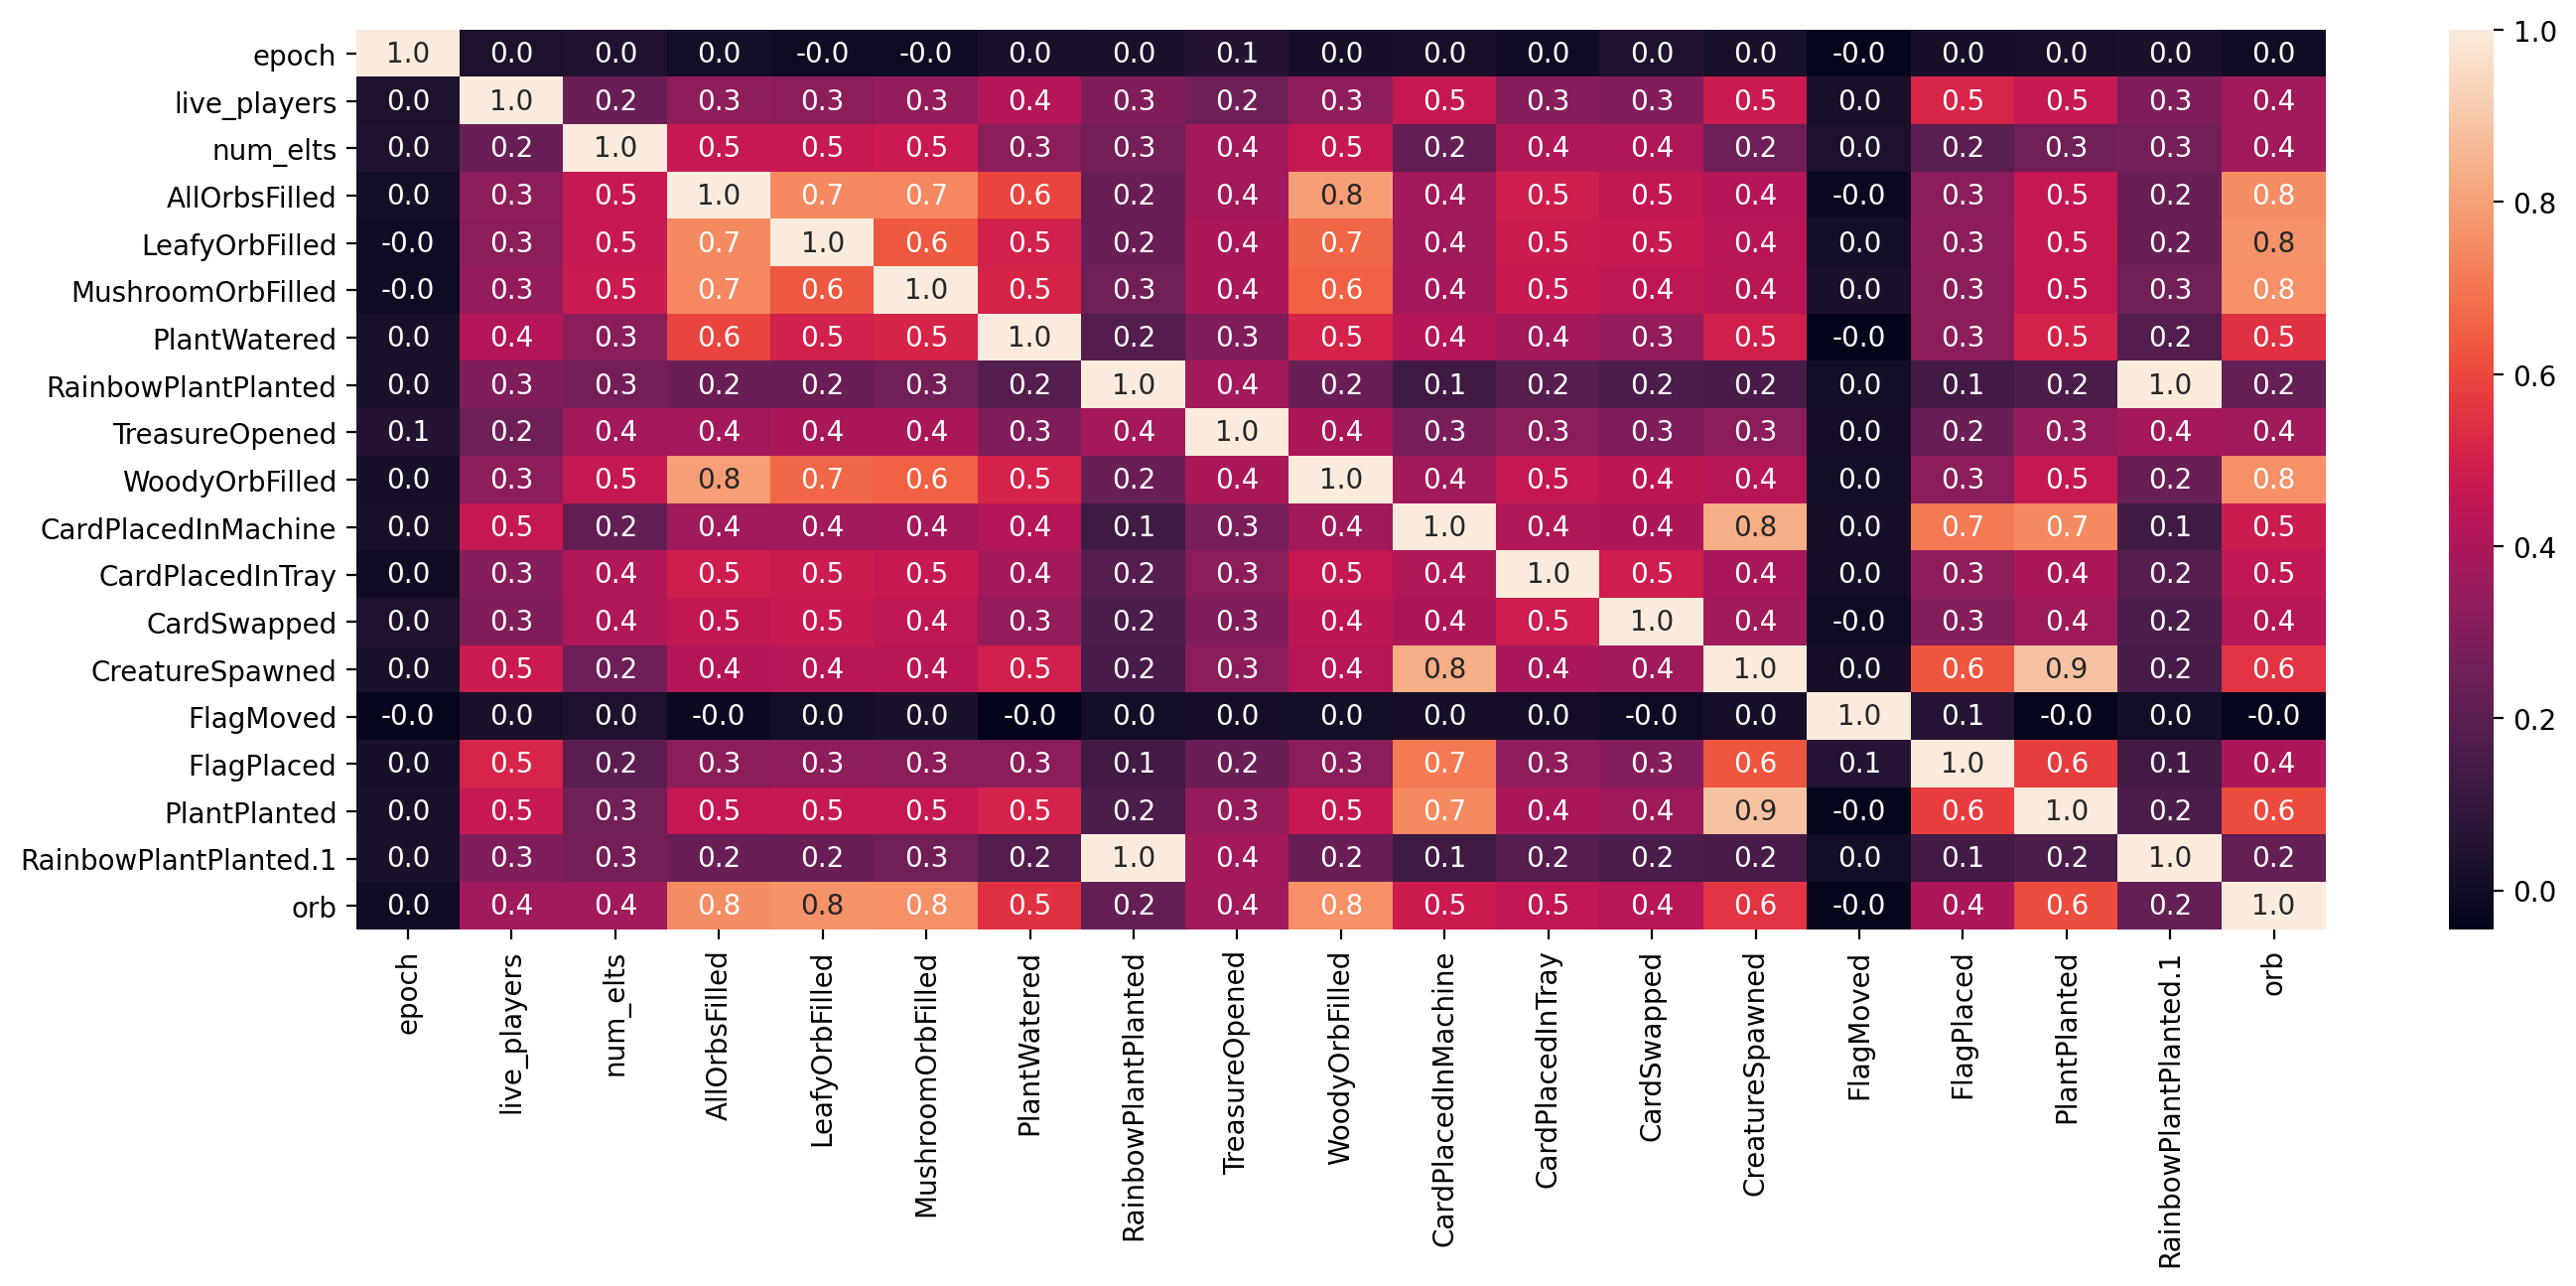

In [18]:

plt.figure(figsize=(16, 6))
dfcorr = dflive.corr()
sns.heatmap(dfcorr, annot=True, fmt='.1f')
plt.show()

### two players more things happen?
- increase in orbs filled + treasure MORE than increase in action?
    - progress = b1\*x1  + b2\*x2 + ...
- similarity of action correlated to orb-filling?
    - e.g. if both players are using the same actions (as opposed to different actions) is there a higher likelihood of an orb filling event
    - this is interesting because maybe it's syncronicity (in the sting sense) or (opposite) maybe it's roles!
- p(diversity_of_creatures \* complexity_of_creature | live_players)
- ? p(orbsfilled>2 | live players, orbsfilled>1)
- p(appropriate_plant_planted | orb_in_need_of_filling, live_players)

### is there more productive play when there are two players
- is dwell time increased?
- not just "more actions, more better" (MC) but somehow intentional

### todo
- score = f(card diversity, creature diversity, plant diversity) 
    - level_of_machine * plants_planted + different_types_of_plant
    - max the spread
    - check off a list of 20 possible states?
    - "a greater variety of possibilities"
    - count diversity of landscape & magnitude of different bins
    - entropy? (simpson's diversity index)
        - measure of garden / cards / actions
    - log likelihood / surprise / possibilities vs. actualities

- "when people are engaged in JCT, they are _inspired_ to engage in a wider variety of experiences?"
    - special/unique vs. i wanna be like them

- player modeling - solo vs joint
    - no 'segmentation' when analyzing results

- literally how much machines were successful in planting plants

- identify "sequential surprise" and compare models for surprise
    - "action trees that follow"
        - e.g. select a card ->
    - where would expect to be surprised?
        - p(machine,card|possibilities,x_t-1,...,beta_1-n*x_t-n)
            - just the cards they chose
            - some kids choose cards based on specific criteria
            - how much shunting to specific cards
        - (measure extraordinary success events?)
    
### vishesh 2021MARCH4
- creature spawn as an episode
    - how much time spent in flagplaced?
    - which animal
    - next to treasure box or plant?


In [19]:
dflive.size

30286

In [20]:
from collections import defaultdict, Counter

# def board_plants(elt):
#     output = []
#     if 'plants' not in elt:
#         return output
#     plants = elt['plants']
#     for plant_id in plants:
#         plant = plants[plant_id]
#         output.append((plant['x'],plant['y'],plant['plantType'],plant['playerWhoPlanted']))
#     return sorted(output)

plant_types = ['Woody','Mushroom','Leafy','Rainbow']
players = ['Player1', 'Player2']

def score_board_plant_diversity(elt):
    output = []
    if 'plants' not in elt or '0' not in elt['plants']:
        return output
    by_player = defaultdict(list)
    plants = [elt['plants'][k] for k in elt['plants']]
    for plant in plants:
        player = str(plant['playerWhoPlanted'])
        plant_type = plant['plantType']
        by_player[player].append(plant_type)
        if plant_type == 'Rainbow':
            for p in players:
                by_player[p].append(plant_type)
    for player in players:
        pc = Counter(by_player[player])
        output.append([player]+[pc[x] for x in plant_types])
    return output
    
random_elts = random.sample(lawrence_data, k=10)
for elt in random_elts:
#     print(board_plants(elt))
    print(score_board_plant_diversity(elt))

[['Player1', 25, 27, 20, 0], ['Player2', 6, 9, 13, 0]]
[['Player1', 8, 7, 12, 1], ['Player2', 12, 14, 9, 1]]
[['Player1', 13, 10, 10, 1], ['Player2', 3, 15, 7, 1]]
[['Player1', 1, 3, 4, 0], ['Player2', 4, 0, 3, 0]]
[['Player1', 1, 2, 1, 0], ['Player2', 3, 3, 2, 0]]
[['Player1', 0, 0, 0, 0], ['Player2', 0, 2, 0, 0]]
[['Player1', 0, 0, 0, 0], ['Player2', 2, 3, 0, 0]]
[['Player1', 2, 5, 4, 0], ['Player2', 6, 3, 2, 0]]
[['Player1', 3, 3, 2, 0], ['Player2', 2, 6, 2, 0]]
[['Player1', 3, 7, 8, 3], ['Player2', 4, 1, 3, 3]]


In [ ]:
output = []
field_types = ['line','player']+plant_types
line_count = 0
for elt in lawrence_data:
    line_count += 1
    plant_type_scores = score_board_plant_diversity(elt)
    for p in plant_type_scores:
        if p:
            output.append([line_count]+p)
pcs = pd.DataFrame(output,columns=field_types)
pcs.head()

In [ ]:
pcs['total'] = (pcs.Woody + pcs.Mushroom + pcs.Leafy)

pcs['score'] = 1 - (pcs.Woody * (pcs.Woody - 1)  + pcs.Mushroom * (pcs.Mushroom - 1) + pcs.Leafy * (pcs.Leafy - 1)) / (pcs.total * (pcs.total - 1))


sns.lineplot(data=pcs, x='line', y='score', hue='player')

# board score vs. solo score? account for diversity of machine as well
# bucket by player change?
# <time, p1id, p2id, solo?,
# p1_plant_diversity_score, p2_plant_diversity_score, board_plant_diversity_score, 
# p1_machine_diversity_score, p2_machine_diversity_score, board_machine_diversity_score>

In [ ]:
choice_event_keys

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(dflive[choice_event_keys],dflive.orb, test_size=0.1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [ ]:
model = MultinomialNB().fit(X_train, y_train)
print(f"{model.score(X_test,y_test):.2f}")
# print(confusion_matrix(y_test, predicted))
print(",".join(choice_event_keys))
# print(list(map(lambda x : int(100 * (2 ** x)), model.feature_log_prob_[0])))
pize = lambda x : int(100 * (2 ** x))
not_orbbed = map(pize, model.feature_log_prob_[0])
orbbed = map(pize,model.feature_log_prob_[1])
 
print(list(map(lambda a,b: a-b,orbbed,not_orbbed)))

In [ ]:
clf = DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train, y_train)
tree.plot_tree(clf, filled=True, feature_names=choice_event_keys, class_names=["no orb","orb"]) 
print(f"{clf.score(X_test,y_test):.2f}")


In [ ]:
model = RandomForestClassifier().fit(X_train, y_train)
print(f"{model.score(X_test,y_test):.2f}")
# print(confusion_matrix(y_test, predicted))

In [ ]:
model = MLPClassifier(max_iter=1000,hidden_layer_sizes=(300,)).fit(X_train, y_train)
print(f"{model.score(X_test,y_test):.2f}")
# print(confusion_matrix(y_test, predicted))
# model.loss_curve_

In [82]:
# p(diversity_of_creatures * complexity_of_creature | live_players)
creatures = [f"player{i}Creature{j}" for i in range(1,3) for j in range(1,4)]

def find_creatures_in_elt(elt):
    output = []
#     for player in range(2):
    for creature in creatures:
        if creature in elt:
            if 'cardsExecuted' in elt[creature]:
                if (elt[creature]['cardsExecuted'] > 0):
                    if len(output) < 2:
                        output = [[],[]]
                    out_creature = {k: elt[creature][k] for k in creature_stats}
                    out_creature['creature'] = creature
                    output.append(out_creature)
    return list(filter(lambda x : x, output))

machine_types = ['Conditional','Sequential','Probability']
def max_by_player(elts_by_player):
    output = {k: {} for k in machine_types}
    for elts in elts_by_player:
        for elt in elts:
            for machine_type in machine_types:
                try:
                    if elt['machineType'] == machine_type:
                        if 'cardsExecuted' not in output[machine_type] or elt['cardsExecuted'] > output[machine_type]['cardsExecuted']:
                            output[machine_type] = elt
                except:
                    print("ERROR:",elt)
    return output

random_elts = random.sample(lawrence_data, k=1)
for elt in random_elts:
    display(find_creatures_in_elt(elt))

[{'cardsExecuted': 119,
  'machineType': 'Conditional',
  'plantsPlanted': 0,
  'plantsWatered': 30,
  'starsEarned': 2,
  'creature': 'player1Creature3'}]

In [ ]:
from itertools import chain, accumulate

# def creature_score(elts):
#     return list(map(find_creatures_in_elt,elts))
#     creature_stats_by_elt = map()

# random_elts = random.sample(lawrence_data, k=2)
# list(map(lambda x: x[0][0] if len(x) > 0 and len(x[0]) > 0 else {}, (creature_score(random_elts))))

In [ ]:
# player2Creature3


In [ ]:
def shorten_creature(creaturePN):
    # player2Creature2 -> p2C2
    return f"p{creaturePN[6]}C{creaturePN[-1]}"

print(shorten_creature("player2Creature2"))


MAX_BY_STAT = 25
def creature_to_id(creature):
#    print(creature)
    if 'machineType' not in creature or not creature['machineType']:
        return ""
    c_pn = shorten_creature(creature['creature'])
    c_mt = creature['machineType'][0]
    c_pp = min(MAX_BY_STAT,int(creature['plantsPlanted']))
    c_pw = min(MAX_BY_STAT,int(creature['plantsWatered']))
    c_se = min(MAX_BY_STAT,int(creature['starsEarned']))
    return f"{c_pn}-{c_mt}-{c_se:>01d}:{c_pp:>02d}.{c_pw:>02d}"

def creature_to_score(creature):
#    print(creature)
    if 'machineType' not in creature or not creature['machineType']:
        return 0
    c_pn = int(creature['creature'][6])-1
    c_mt = creature['machineType'][0]
    s_mt = 0
    if c_mt == 'S': 
        s_mt = 1
    elif c_mt == 'P': 
        s_mt = 2
    elif c_mt == 'C': 
        s_mt = 3
    c_pp = min(MAX_BY_STAT,int(creature['plantsPlanted']))
    c_pw = min(MAX_BY_STAT,int(creature['plantsWatered']))
    c_se = min(MAX_BY_STAT,int(creature['starsEarned']))
    final_score = s_mt * (1 + c_pp) * c_se
    return (c_pn,final_score)

def elt_to_scores(elt):
    scores = [0,0]
    cs = map(lambda c: creature_to_score(c),  find_creatures_in_elt(elt))
    for c in cs:
        scores[c[0]] += c[1]
    return scores
    
def elt_to_creaturelist(elt):
    return list(map(creature_to_id,find_creatures_in_elt(elt)))
    
def elts_to_creaturelist(elts):
#     return list(filter(lambda x : x, map(elt_to_creaturelist,elts)))
    return list(map(elt_to_creaturelist,elts))
    
random_elts = random.sample(lawrence_data, k=3)
print(elts_to_creaturelist(random_elts))
print(list(map(lambda elt: list(map(lambda c: creature_to_score(c),  find_creatures_in_elt(elt))),random_elts)))
print(list(map(lambda elt: elt_to_scores(elt),random_elts)))

# for elt in random_elts:
#     for c in find_creatures_in_elt(elt):
#         print(creature_to_id(c))        
#     print("---")
##     for player in range(2):
##         for creature in creatures[player]:
##             if creature in elt and (elt[creature]['cardsExecuted'] > 0):
##                 print(f"{1 + player} {creature}: {elt[creature]}")



In [ ]:
def filter_by_key(pKey):
    return filter(lambda x : x['eventKey'] == pKey, lawrence_data)
#     return random.choice(list(filtered_by_key))



In [ ]:
all_creatures = elts_to_creaturelist(lawrence_data)
print(len(all_creatures))
print(random.sample(all_creatures,k=5))

In [ ]:
def diff_creature_rows(elts):
    output = []
    last_row = []
    for row in elts:
        diff_rows = [c for c in row if c not in last_row]
        output.append(diff_rows)
        last_row = row
    return output
# print(all_creatures[:10])
# print(diff_creature_rows(all_creatures[:10]))
diffed_rows = diff_creature_rows(all_creatures)
print(len(diffed_rows),"?=",len(all_creatures),"?=",len(lawrence_data))

In [ ]:
# display(lawrence_data[200000])
# display(all_creatures[200000])

all_scores = list(map(lambda elt : elt_to_scores(elt), lawrence_data))
len(all_scores)

In [ ]:
t = list(map(lambda elt: int(elt['timeEpoch']), lawrence_data))
# p1 = list(zip(t,list(map(lambda s : s[0], all_scores))))
# p2 = list(zip(t,list(map(lambda s : s[1], all_scores))))
# p1f = list(filter(lambda xy: xy[1] != 0, p1))
# p2f = list(filter(lambda xy: xy[1] != 0, p2))
ps = list(zip(t,list(map(lambda s : s[0], all_scores)),list(map(lambda s : s[1], all_scores))))


In [ ]:
df = pd.DataFrame(ps,columns=['time','p1score','p2score'])
df.plot.line(x='time',y='p1score')

In [ ]:
df.plot.line(x='time',y='p2score')